In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from pyfonts import load_font

In [2]:
# Load the data
df = pd.read_csv('IIP_2021IcebergSeason.csv')
df.head(2)

,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE
0,2021,22,10/1/2020,2133,55.19833,-58.19500,SAT-HIGH,GEN,GEN,RCM1
1,2021,12,10/2/2020,2109,54.73667,-50.63833,SAT-HIGH,GEN,GEN,RCM2


In [3]:
# Function to clean and prepare the data
def clean_df(df):     

    # Rename specific columns and to correct size and shame column headers that are swapped
    df = df.rename(columns=
                   {'ICEBERG_YEAR': 'year',
                    'ICEBERG_NUMBER': 'id',
                    'SIGHTING_DATE': 'date',
                    'SIGHTING_TIME': 'time',
                    'SIGHTING_LATITUDE': 'latitude',
                    'SIGHTING_LONGITUDE': 'longitude',
                    'SIGHTING_METHOD': 'method',
                    'SIZE': 'shape',
                    'SHAPE': 'size',
                    'SOURCE': 'source'                    
                   })
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.strftime('%m').astype(int)

    # Assign season to months
    def season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Autumn'
        else:
            return 'Unknown'  # Fallback for unexpected values
    
    # Apply season to months
    df['season'] = df['month'].apply(season)

    # Create a count column
    df['count'] = 1

    # Assign proportional measures to size
    size_dict = {'GEN': 10,
                 'RAD': 10,
                 'GR': 0.01,
                 'BB': 0.1,
                 'SM': 1,
                 'MED': 20,
                 'LG': 100,
                 'VLG': 110
                 }
    
    # Apply measure to size
    df['size'] = df['size'].replace(size_dict)

    return df

In [4]:
# Apply the cleaning function
df = clean_df(df)

/tmp/ipykernel_695037/494969596.py:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['size'] = df['size'].replace(size_dict)


In [5]:
# Load json file without Antartica
world = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json')
world = world[world['name']!= 'Antarctica']

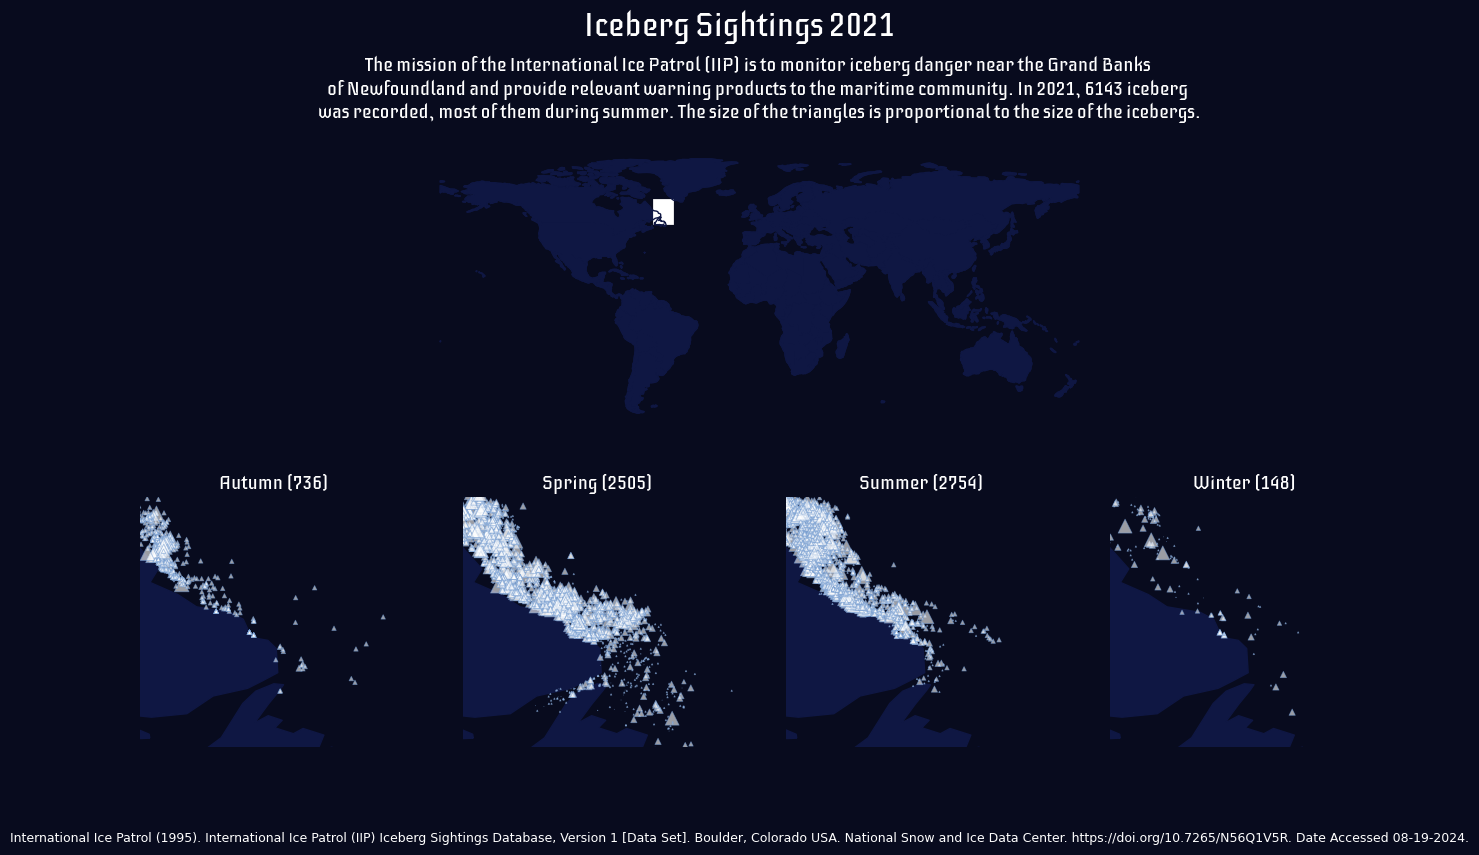

In [6]:
# Assign colors
bg_col = '#080B1E'
map_col = '#0F1743'
main_col = '#ffffff'

# Load font
font = load_font(
    font_url="https://github.com/google/fonts/blob/main/ofl/iceberg/Iceberg-Regular.ttf?raw=true")

# Create figure 
fig = plt.figure(figsize=(16, 8),facecolor=bg_col)

# Create a GridSpec with 2 rows and 4 columns
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1])

# Create main map plot 
ax_main = fig.add_subplot(gs[0, :])  
world.boundary.plot(ax=ax_main, linewidth=1, edgecolor=map_col)
world.plot(ax=ax_main, color=map_col, edgecolor=map_col)

# Define the rectangle using the coordinates
rect = box(-59.3, 48.7, -49.4, 61.6)

# Add the rectangle to the main map plot
ax_main.add_patch(plt.Rectangle(
    (-59.3, 48.7),  
    9.9,         
    12.2,         
    linewidth=2,    
    edgecolor=main_col,   
    facecolor=main_col   
))

# Create text
text="The mission of the International Ice Patrol (IIP) is to monitor iceberg danger near the Grand Banks \nof Newfoundland and provide relevant warning products to the maritime community. In 2021, 6143 iceberg \nwas recorded, most of them during summer. The size of the triangles is proportional to the size of the icebergs."

# Add text to the main map plot
ax_main.set_title(text, font=font, fontsize=14, color=main_col, pad=20)

# Remove axis in the main map plot
ax_main.axis('off')

# Create 4 insets in the second row
inset_axes = [fig.add_subplot(gs[1, i], facecolor=bg_col) for i in range(4)]  

# Calculate the iceberg counts for each season
counts = df.groupby('season').size()

# Plot each season in the corresponding subplot
for ax, (season, group) in zip(inset_axes, df.groupby('season')):
    world.plot(ax=ax, color=map_col, edgecolor=map_col)
    ax.scatter(x=group['longitude'], y=group['latitude'], c=main_col, s=group['size'], marker='^', linewidth=0.6, edgecolor='#739bd0', alpha=0.6)
    # Set limits to insets
    ax.set_xlim((-62.3, -49.4))
    ax.set_ylim((48.7, 60.3))
    # Get the count for the current season and add it to the title
    count = counts[season]
    ax.set_title(f'{season:} ({count})', font=font, fontsize=14, color=main_col)
    # Remove inset axes
    ax.axis('off')

# Add title
fig.suptitle('Iceberg Sightings 2021', x=0.5, y=1.05, font=font, fontsize=24, color=main_col)

# Caption
fig.text(0.5, 0.01, 
         "International Ice Patrol (1995). International Ice Patrol (IIP) Iceberg Sightings Database, Version 1 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/N56Q1V5R. Date Accessed 08-19-2024.",
         ha='center', fontsize=9, color=main_col)

plt.savefig('icebergs_2021.png', transparent=False, dpi=80, bbox_inches="tight")